# ARIMA Modeling

In this section we're going to begin fitting our data to ARIMA models and make predictions about the increase of COVID-19 cases in America.  

Due to time constraints, we will only be modeling the states with the top 5 highest number of cases.  If you remember from notebook 2, those states are California, Florida, Georgia, New York, and Texas.

Time to get started!

# Importing Data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('national_positive_increase.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 57 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           256 non-null    object
 1   AK_positiveIncrease  256 non-null    int64 
 2   AL_positiveIncrease  256 non-null    int64 
 3   AR_positiveIncrease  256 non-null    int64 
 4   AS_positiveIncrease  256 non-null    int64 
 5   AZ_positiveIncrease  256 non-null    int64 
 6   CA_positiveIncrease  256 non-null    int64 
 7   CO_positiveIncrease  256 non-null    int64 
 8   CT_positiveIncrease  256 non-null    int64 
 9   DC_positiveIncrease  256 non-null    int64 
 10  DE_positiveIncrease  256 non-null    int64 
 11  FL_positiveIncrease  256 non-null    int64 
 12  GA_positiveIncrease  256 non-null    int64 
 13  GU_positiveIncrease  256 non-null    int64 
 14  HI_positiveIncrease  256 non-null    int64 
 15  IA_positiveIncrease  256 non-null    int64 
 16  ID_posit

In [3]:
# Rename 'Unnamed' to 'date'
df = df.rename(columns={'Unnamed: 0' : 'date'})

# Changing 'date' to date-time 
df['date'] = pd.to_datetime(df['date'])

# Set to index
df = df.set_index('date')

df = df.asfreq('D')

df.head()

,AK_positiveIncrease,AL_positiveIncrease,AR_positiveIncrease,AS_positiveIncrease,AZ_positiveIncrease,CA_positiveIncrease,CO_positiveIncrease,CT_positiveIncrease,DC_positiveIncrease,DE_positiveIncrease,...,TN_positiveIncrease,TX_positiveIncrease,UT_positiveIncrease,VA_positiveIncrease,VI_positiveIncrease,VT_positiveIncrease,WA_positiveIncrease,WI_positiveIncrease,WV_positiveIncrease,WY_positiveIncrease
date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Alright, now that the dataframe is loaded up, let's subset the data of our top 5 states into their own dataframes.

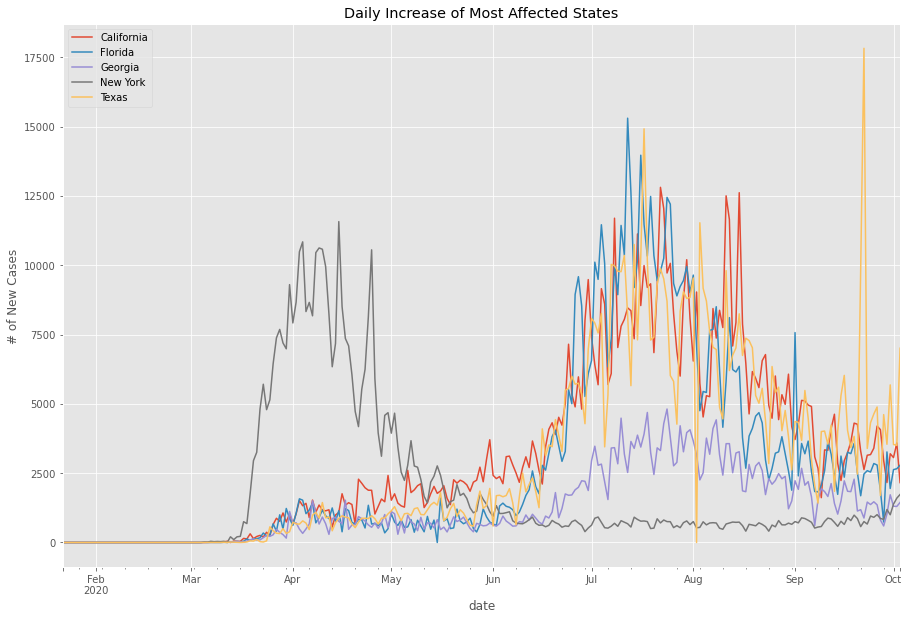

In [4]:
# California
ca = df['CA_positiveIncrease']
ca.plot(figsize=(15, 10), label='California')

# Florida
fl = df['FL_positiveIncrease']
fl.plot(figsize=(15, 10), label='Florida')

# Georgia
ga = df['GA_positiveIncrease']
ga.plot(figsize=(15, 10), label='Georgia')

# New York
ny = df['NY_positiveIncrease']
ny.plot(figsize=(15, 10), label='New York')

# Texas
tx = df['TX_positiveIncrease']
tx.plot(figsize=(15, 10), label='Texas')

plt.ylabel('# of New Cases')
plt.title('Daily Increase of Most Affected States')
plt.legend()
plt.show();

Awesome! We remember this messy plot from notebook 2!  Now, since we only have data between the end of January and the beginning of October, we shouldn't need to resample.  256 values per state is low enough, all things considered. If we resampled by the week, that would leave us with ~ 36 weeks, which might not be a enough data to get accurate data.  

# Grid Search Parameters

Thanks to the "integrated" nature of ARIMA Time Series Models, we don't need to check for stationarity manually.  Instead, that will take place as we calculate our parameters for the number of auto-regressive terms, differences, and the moving average terms(or the `p, d, q` values).  Calculating the differences will make our model stationary for us!

For now, we'll start small and see what yields the best AIC score.

In [13]:
def pdq_parameters(timeseries, range_ = 2, s = 0):
    '''
    Input: Time Series Dataframe, range values for ARIMA(p, d, q), and an 
    optional value for seasonality (s).
    
    The function will generate values between within the given range (default 
    between 0 and 1) for p, d, and q, compile them into lists and run them 
    through a model fit to the given time series.
    
    It will return a list of the parameters and their associate AIC scores.  
    '''

    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(range_)

    # Generate all combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    pdqs = [(x[0], x[1], x[2], s) for x in list(itertools.product(p, d, q))]

    # Finding optimal results
    results = []
    for combination in pdq:
        for combinations in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(timeseries,
                                                order=combination,
                                                seasonal_order=combinations,
                                                enforce_stationarity=True,
                                                enforce_invertibility=False)

                output = mod.fit()
                results.append([combination, combinations, output.aic])
            
            except:
                continue
    return results

In [16]:
pdq_parameters(ca, 2, 12)

[[(0, 0, 0), (0, 0, 0, 12), 5014.221176728972],
 [(0, 0, 0), (0, 0, 1, 12), 4680.082081439222],
 [(0, 0, 0), (0, 1, 0, 12), 4376.683209287141],
 [(0, 0, 0), (0, 1, 1, 12), 4165.368510196296],
 [(0, 0, 0), (1, 0, 0, 12), 4386.925187460292],
 [(0, 0, 0), (1, 0, 1, 12), 4365.780144201237],
 [(0, 0, 0), (1, 1, 0, 12), 4177.913306933662],
 [(0, 0, 0), (1, 1, 1, 12), 4158.434789534451],
 [(0, 0, 1), (0, 0, 0, 12), 4832.342316622536],
 [(0, 0, 1), (0, 0, 1, 12), 4428.411147072317],
 [(0, 0, 1), (0, 1, 0, 12), 4299.247988760227],
 [(0, 0, 1), (0, 1, 1, 12), 4073.6480108662245],
 [(0, 0, 1), (1, 0, 0, 12), 4318.083024992536],
 [(0, 0, 1), (1, 0, 1, 12), 4267.183741912089],
 [(0, 0, 1), (1, 1, 0, 12), 4099.213529351629],
 [(0, 0, 1), (1, 1, 1, 12), 4067.8861716537244],
 [(0, 1, 0), (0, 0, 0, 12), 4328.869048336717],
 [(0, 1, 0), (0, 0, 1, 12), 4131.3459505942665],
 [(0, 1, 0), (0, 1, 0, 12), 4339.328240781445],
 [(0, 1, 0), (0, 1, 1, 12), 3965.592471590636],
 [(0, 1, 0), (1, 0, 0, 12), 4147.2610

If I set the seasonality parameter to "8" (representing the 8 months of covid) our best parameters are (1, 1, 1,) x (1, 1, 1, 8) 